In [ ]:
# EXamples of single-subject/single run fMRI data analyses

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nistats
from nistats.first_level_model import FirstLevelModel
from nistats.design_matrix import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_glass_brain

In [2]:
# First example: analysis of continuous speech processing, with precomputed design matrix

# specify data
imgs = 'data/lpp-run1.nii'

# load precomputed design matrix
dtx_mat = pd.read_csv('data/lpp-run1_model01.csv', delimiter='\t')
dtx_mat.head()

,wordrate,freq,bottomup,mwe,rms,f0
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.001159,0.007566,0.002229,0.0,0.001596,1.998070
2,0.093783,0.646868,0.176013,0.0,0.031892,41.955294
3,0.328313,2.338574,0.624197,0.0,0.087001,131.346285
4,0.511194,3.675699,0.865432,0.0,0.121853,201.186070


Computing run 1 out of 1 runs (go take a coffee, a big one)
Masker took 8 seconds          
/home/cp983411/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/first_level_model.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
GLM took 3 seconds         

Computation of 1 runs done in 11 seconds



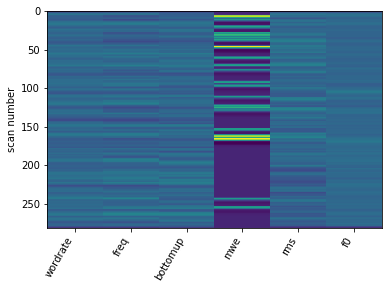

In [3]:
# create the linear model and estimate it

fmri_glm = FirstLevelModel(
            t_r = 2.0,
            hrf_model = 'spm',
            # mask='mask_ICV.nii',
            noise_model = 'ar1',
            period_cut = 128.0,
            smoothing_fwhm = 0,
            minimize_memory = True,
            # memory='/mnt/ephemeral/cache',
            memory = None,
            verbose = 2,
            n_jobs = 1)

fmri_glm = fmri_glm.fit(imgs, design_matrices=dtx_mat)

#display the design matrix
from nistats.design_matrix import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

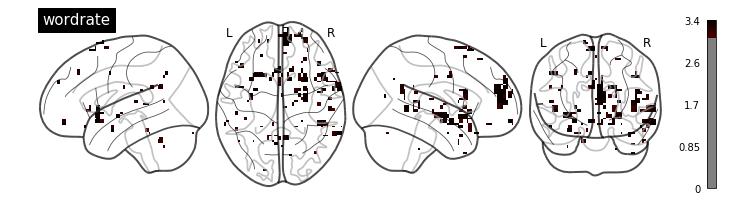

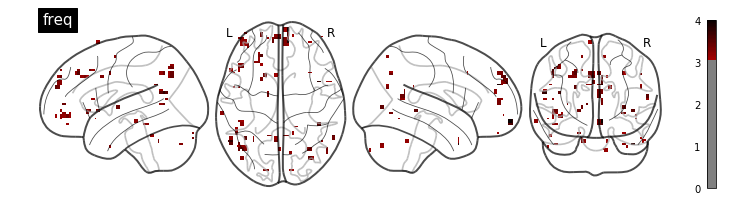

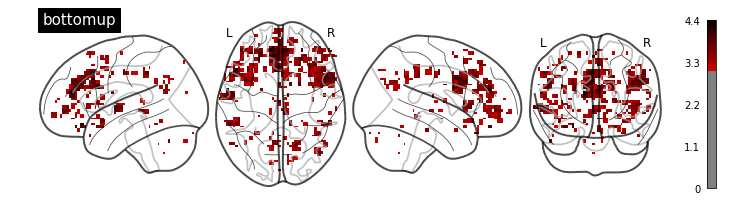

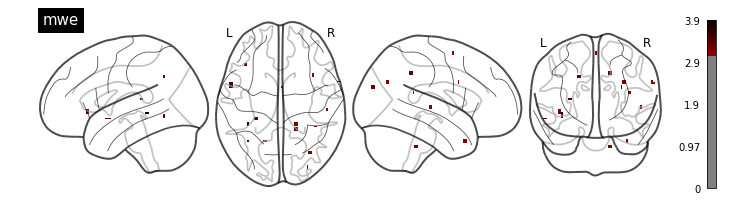

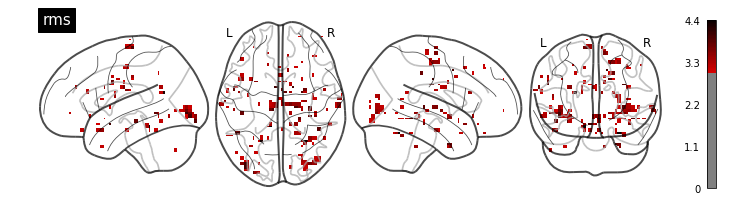

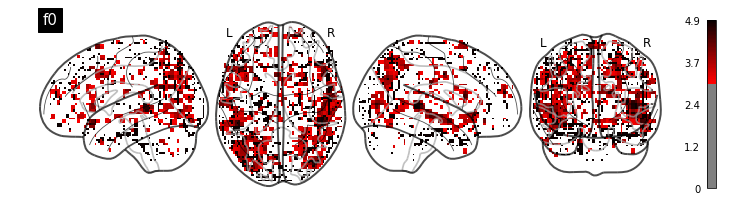

In [5]:
# display the zmap for each regressor 

nreg = dtx_mat.shape[1]  # number of regressors
for i, name in enumerate(dtx_mat.columns):
        con = np.zeros(nreg)  # zeros everywhere
        con[i] = 1  # except in the relevant column

        z_map = fmri_glm.compute_contrast(con, output_type='z_score')
        eff_map = fmri_glm.compute_contrast(con, output_type='effect_size')
        #nib.save(z_map, op.join(outputpath, '%s_%s_zmap.nii.gz' % (name, subjid)))
        #nib.save(eff_map, op.join(outputpath, '%s_%s_effsize.nii.gz'% (name, subjid)))
        #display = None
        display = plot_glass_brain(z_map, 
                                   display_mode = 'lzry', 
                                   threshold = 3.1, 
                                   colorbar = True, 
                                   title = name)
        plt.show()
        #display.savefig(op.join(outputpath, '%s_%s_glassbrain.png' % (name, subjid)))
        #display.close()


In [ ]:
fmri_glm.compute_contrast


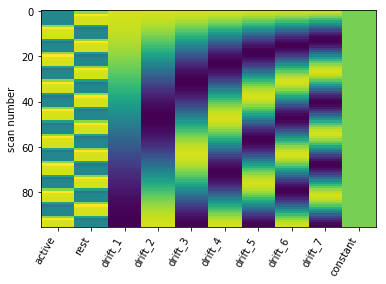

In [6]:
### Second example: analysis of SPM's auditory dataset (http://www.fil.ion.ucl.ac.uk/spm/data/auditory/)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# specify the data
from nilearn.image import mean_img
epi = 'data/auditory/auditory-epi.nii.gz'
mean_img = mean_img(epi)  # for display purposes because we are not in the 


# create and estimate the model
from nistats.first_level_model import FirstLevelModel
from nistats.design_matrix import plot_design_matrix

tr = 7.  # in seconds
n_scans = 96
# the paradigm is an alternance of blocks of rest and auditory stimulation 
# each block lasts for 6 scans, and there is a total of 16 blocs
paradigm = pd.DataFrame(
    {'trial_type': ['rest', 'active'] * 8, 
     'onset': np.arange(0, 16) * 6 * tr,
     'duration': 6 * tr})

#########################################################################
# Construct design matrix
fmri_glm = FirstLevelModel(tr, 0., noise_model='ar1',
                           standardize=False, 
                           hrf_model='spm',
                           drift_model='Cosine', 
                           period_cut=160)
fmri_glm = fmri_glm.fit(epi, paradigm)

design_matrix = fmri_glm.design_matrices_[0]
from nistats.design_matrix import plot_design_matrix
plot_design_matrix(design_matrix)
plt.show()





	contrast id: active-rest


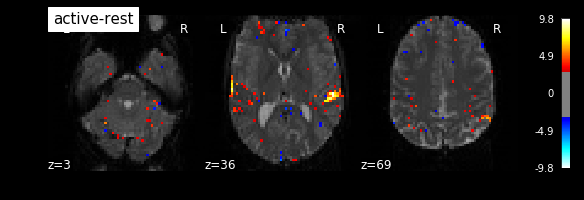

In [7]:
# Contrast active - rest

from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_glass_brain

contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])

contrasts = {'active-rest': contrasts['active'] - contrasts['rest']}

for contrast_id, contrast_val in contrasts.items():
    print("\tcontrast id: %s" % contrast_id)
    z_map = fmri_glm.compute_contrast(contrasts[contrast_id],
                                      output_type='z_score')
    t_map = fmri_glm.compute_contrast(contrasts[contrast_id],
                                      output_type='stat')
    eff_map = fmri_glm.compute_contrast(contrasts[contrast_id],
                                        output_type='effect_size')
    var_map = fmri_glm.compute_contrast(contrasts[contrast_id],
                                        output_type='effect_variance')
    display = plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
                            display_mode='z', cut_coords=3, black_bg=True,
                            title=contrast_id)

    plt.show()

   

In [8]:
fmri_glm.compute_contrast?